### Python MLE v/s PYMC3 

#### Team members: Sakshee Naik, Shaurya Agrawal

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv(r"C:\Users\lenovo\Downloads\forestfires.csv")
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


The dataset is of the meteorological and other data of forests in Northeast region of Portugal.

In [4]:
temperatures = df['temp']

Text(0.5, 0, 'Temperatures')

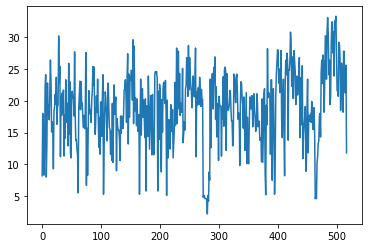

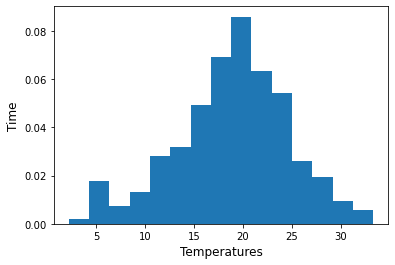

In [5]:
plt.figure(0)
plt.plot(temperatures)

plt.figure(1)
plt.hist(temperatures, bins=15, density=True)
plt.ylabel('Time', fontsize=12)
plt.xlabel('Temperatures', fontsize=12)

C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='temp'>

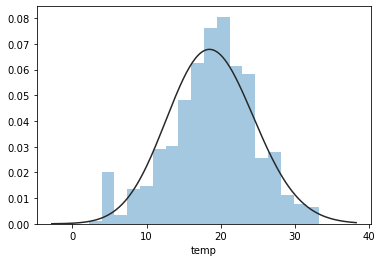

In [6]:
from scipy import stats

sns.distplot(temperatures,kde=False, fit=stats.gamma)

The dataset fits the gamma distribution, next step is to calculate α and β using MLE

In [7]:
from scipy.optimize import newton
import pandas as pd
from scipy.special import psi, polygamma

dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

In [9]:
import math as ma

log_mean = ma.log(temperatures.mean())
mean_log = temperatures.apply(np.log).mean()

In [10]:
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean, mean_log))
alpha_mle

8.093808162445182

In [12]:
beta_mle = alpha_mle/temperatures.mean()
beta_mle

0.42848938836787526

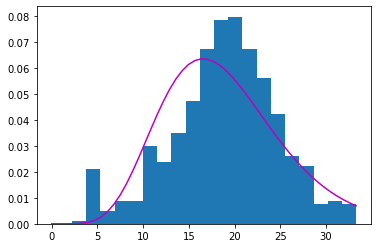

In [13]:
from scipy.stats.distributions import gamma

temperatures.hist(density=True, bins=20, grid=False)
x = np.linspace(0, temperatures.max())
plt.plot(x, gamma.pdf(x, a = alpha_mle, scale = 1/beta_mle), 'm-')

In [14]:
from scipy.stats import gamma

gamma.fit(temperatures)

(288.7443545804754, -81.15253907474926, 0.34629360286205235)

### Repeating the same using PYMC3

In [15]:
mean = temperatures.mean()
mean

18.88916827852998

In [16]:
std = temperatures.std()
std

5.806625349573503

In [17]:

from pymc3 import StudentT, Normal
from pymc3 import Model, Uniform


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [18]:
with Model() as temperatures_model:
    μ = Normal('μ', mean, sd=std)

In [19]:
with temperatures_model:
    σ = Uniform('σ', lower=0, upper=20)

In [20]:
from pymc3 import Exponential

with temperatures_model:
    ν = Exponential('ν_minus_one', 1/29.) + 1

In [21]:
with temperatures_model:
    temperatures_like = StudentT('temperatures_like', nu=ν, mu=μ, lam=σ**-2, observed=temperatures)

In [ ]:
from pymc3 import fit

with temperatures_model: 
    temperatures_trace = fit(random_seed=20210306).sample(1000)

C:\Users\shaur\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


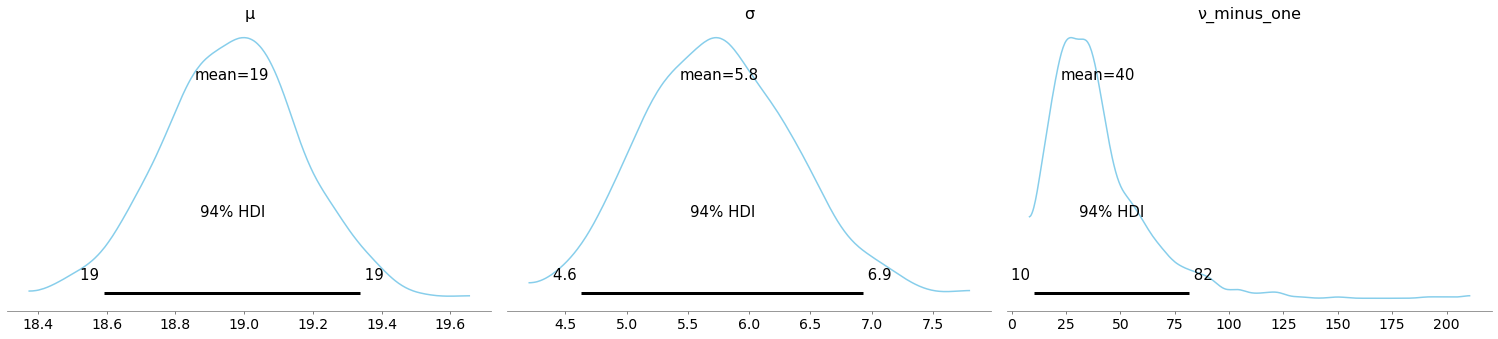

In [83]:
from arviz import plot_posterior

plot_posterior(temperatures_trace[100:], 
                var_names=['μ', 'σ', 'ν_minus_one'],
                color='#87ceeb');


C:\Users\shaur\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

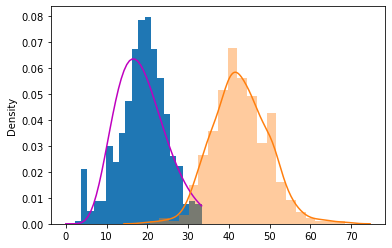

In [84]:
temperatures.hist(density=True, bins=20, grid=False)
plt.plot(x, gamma.pdf(x, a = alpha_mle, scale = 1/beta_mle), 'm-')
t = StudentT.dist(nu = 29, mu = 42, lam = 7.1**-2).random(size = 365)
sns.distplot(t)

#### We as a team have performed MLE and pymc3 for various datasets and we can conclude that the ease of use of either methods can vary as per datasets and their central tendencies.